# Hello World

This notebook walks through basic code examples for integrating various packages with Neo4j, including `py2neo`, `ipython-cypher`, `pandas`, `networkx`, `igraph`, and `graph3d`.

# py2neo

`py2neo` is one of Neo4j's Python drivers. It offers a fully-featured interface for interacting with your data in Neo4j. Install `py2neo` with `pip install py2neo`.

## Connect

Connect to Neo4j with the `Graph` class.

In [23]:
from py2neo import Graph
from scripts.vis import draw
from py2neo import authenticate, Graph

# set up authentication parameters
authenticate("localhost:7474", "neo4j", "1")

graph = Graph("http://localhost:7474/db/data/")



In [165]:
# graph.delete_all()

## Nodes

Create nodes with the `Node` class. The first argument is the node's label. The remaining arguments are an arbitrary amount of node properties or key-value pairs.

In [38]:
from py2neo import Node

# import post nodes
query="""
USING PERIODIC COMMIT \

LOAD CSV WITH HEADERS FROM "file:/Users/Zhen/desktop/Courses/Bigdata/stackexchange/data/post2.csv" AS row FIELDTERMINATOR ';' \

CREATE (:post {ID: row.ID, CreationDate:row.CreationDate,  Tags:row.Tags, ViewCount:row.ViewCount, FavoriteCount:row.FavoriteCount, Label:row.LABEL });

"""
graph.cypher.execute(query)


In [39]:
# Add a user nodes
query="""
USING PERIODIC COMMIT

LOAD CSV WITH HEADERS FROM "file:/Users/Zhen/desktop/Courses/Bigdata/stackexchange/data/user.csv" AS row FIELDTERMINATOR ';'

CREATE (:user {ID: row.Id, Reputation: row. Reputation, CreationDate:row.CreationDate,  Location:row. Location, UpVotes:row. UpVotes, DownVotes:row. DownVotes, Age:row. Age, Label:row.LABEL });
"""
graph.cypher.execute(query)

In [41]:
# Add a post answer a question relation
query="""
USING PERIODIC COMMIT

LOAD CSV WITH HEADERS FROM "file:/Users/Zhen/desktop/Courses/Bigdata/stackexchange/data/post_relation.csv" AS row2 FIELDTERMINATOR ';'
MATCH (u:post),(p:post)
where  u.ID=row2.START_ID and p.ID=row2.END_ID
MERGE (u) -[t :Answer]-> (p) ;
"""
graph.cypher.execute(query)

ERROR:httpstream:! SocketError: timed out


SocketError: timed out

In [ ]:
# Add a person answer a question relation
query="""
USING PERIODIC COMMIT
LOAD CSV WITH HEADERS FROM "file:/Users/Zhen/desktop/Courses/Bigdata/stackexchange/data/userPoste.csv" AS row2 FIELDTERMINATOR ';'
MATCH (u:user),(p:post)
WHERE u.ID=row2.OwnerUserId and p.ID=row2.Id and row2.Type='answer'
MERGE (u) -[t :Answer]-> (p)
"""
graph.cypher.execute(query)

In [ ]:
# Add a person answer a question relation
query="""
USING PERIODIC COMMIT
LOAD CSV WITH HEADERS FROM "file:/Users/Zhen/desktop/Courses/Bigdata/stackexchange/data/userPoste.csv" AS row2 FIELDTERMINATOR ';'
MATCH (u:user),(p:post)
WHERE u.ID=row2.OwnerUserId and p.ID=row2.Id and row2.Type='answer'
MERGE (u) -[t :Answer]-> (p)
"""
graph.cypher.execute(query)

In [21]:
import numpy as np
import pandas as pd
query="""
MATCH (u:user)-[t:Answer]->(p:answer)
RETURN u.ID as ID, count(*) AS answerCount
ORDER BY answerCount DESC
LIMIT 10
"""
most_answer_person = graph.cypher.execute(query)
most_answer_person

    | ID   | answerCount
----+------+-------------
  1 | 2452 |          84
  2 | 381  |          50
  3 | 609  |          32
  4 | 21   |          32
  5 | 434  |          29
  6 | 108  |          25
  7 | 847  |          24
  8 | 1279 |          24
  9 | 819  |          24
 10 | 8878 |          22

In [50]:
import pandas as pd
import numpy as np
most_answer_person_frame=pd.DataFrame(columns=['ID','answerCount'])
a=[]
for row in most_answer_person:
    a.append((row[0],row[1]))
most_answer_person_frame=pd.DataFrame(a,columns=['ID','answerCount'])


In [51]:
most_answer_person_frame

,ID,answerCount
0,2452,84
1,381,50
2,609,32
3,21,32
4,434,29
5,108,25
6,847,24
7,1279,24
8,819,24
9,8878,22


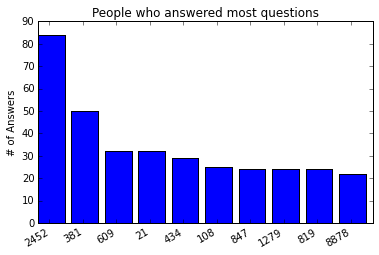

In [62]:
%matplotlib inline  
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

fig = plt.figure()
ind = np.arange(10)  # the x locations for the groups
width = 0.35       # the width of the bars




fig, ax = plt.subplots()
rects1=ax.bar(ind, most_answer_person_frame.iloc[:,1])
fig.autofmt_xdate()

# add some text for labels, title and axes ticks
ax.set_ylabel('# of Answers')
ax.set_title('People who answered most questions')
ax.set_xticks(ind + width)
ax.set_xticklabels(most_answer_person_frame.iloc[:,0])

# ax.legend((rects1[0], rects2[0]), ('Men', 'Women'))


def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

#autolabel(rects1)


plt.show()


In [9]:
%load_ext cypher


In [111]:
query="""
MATCH (u:tag)<-[:hasTag]-(p:ask)-[:hasTag]->(q:tag)
Where toInt(q.ID)>toInt(u.ID)
RETURN u.TagName, q.TagName, count(*) AS tag_cooccurence
ORDER BY tag_cooccurence DESC
"""
tag_cooccurence = graph.cypher.execute(query)
tag_cooccurence


      | u.TagName                 | q.TagName                 | tag_cooccurence
------+---------------------------+---------------------------+-----------------
    1 | machine-learning          | classification            |              76
    2 | machine-learning          | data-mining               |              69
    3 | machine-learning          | r                         |              48
    4 | machine-learning          | python                    |              34
    5 | machine-learning          | neuralnetwork             |              34
    6 | machine-learning          | statistics                |              30
    7 | machine-learning          | algorithms                |              27
    8 | bigdata                   | data-mining               |              26
    9 | machine-learning          | bigdata                   |              26
   10 | machine-learning          | predictive-modeling       |              26
   11 | machine-learning          | dat

In [112]:
a=[]
for row in tag_cooccurence:
    a.append((row[0],row[1],row[2]))
tag_cooccurence_frame=pd.DataFrame(a,columns=['source','target','value'])
#tag_cooccurence_frame['source']=tag_cooccurence_frame['source'].astype('int')
#tag_cooccurence_frame['target']=tag_cooccurence_frame['target'].astype('int')
tag_cooccurence_json=tag_cooccurence_frame.to_json(path_or_buf = None, orient = 'records', date_format = 'epoch', double_precision = 10, force_ascii = True, date_unit = 'ms', default_handler = None) 

In [114]:
with open("tag_graph.json", "w") as f:
    json.dump(json.loads(tag_cooccurence_json),f,ensure_ascii=False,indent=2)

In [109]:
#import json
#tag_graph_json={"nodes":json.loads(tag_json), "links":json.loads(tag_cooccurence_json)}

In [119]:
query="""
MATCH (u:tag)
RETURN u.ID,u.TagName,u.TagCount
"""
tag_node = graph.cypher.execute(query)
a=[]
for row in tag_node:
    a.append((row[0],row[1],row[2]))
tag_frame=pd.DataFrame(a,columns=['ID','Name','Count'])
#tag_frame['group']=tag_frame['name'].astype('int')
#tag_frame['group']=tag_frame['group'].astype('int')
#tag_json=tag_frame.to_json(path_or_buf = None, orient = 'records',  double_precision = 10, force_ascii = True, default_handler = None) 

In [120]:
tag_frame

,ID,Name,Count
0,1,definitions,12
1,2,machine-learning,420
2,3,bigdata,115
3,5,data-mining,171
4,6,databases,19
5,8,libsvm,4
6,10,scalability,16
7,11,efficiency,19
8,12,performance,19
9,13,nosql,12


In [154]:
count=0
df=[];
for i in tag_frame['Name']:
    query="""
            MATCH (u:tag)<-[:hasTag]-(p:ask)-[:hasTag]->(q:tag)
            WHERE u.TagName="%%"
            RETURN u.TagName, q.TagName, count(*) AS tag_cooccurence
            ORDER BY tag_cooccurence DESC
          """.replace("%%",i)
    tag_relate = graph.cypher.execute(query)
    a=(i,100,[row[1] for row in tag_relate])
    df.append(a)
#     count+=1
#     if count >10:
#         break
tag_relation_frame=pd.DataFrame(df,columns=['name','size','imports'])


In [163]:
count=0
df=[];
for i in range(tag_frame.shape[0]):
    query="""
            MATCH (u:tag)<-[:hasTag]-(p:ask)-[:hasTag]->(q:tag)
            WHERE u.TagName="%%"
            RETURN u.TagName, q.TagName, count(*) AS tag_cooccurence
            ORDER BY tag_cooccurence DESC
          """.replace("%%",tag_frame.iloc[i,1])
    tag_relate = graph.cypher.execute(query)
    a=(tag_frame.iloc[i,1],tag_frame.iloc[i,2],[row[1] for row in tag_relate])
    df.append(a)
#     count+=1
#     if count >10:
#         break
tag_relation_frame=pd.DataFrame(df,columns=['name','size','imports'])

In [161]:
tag_frame

,ID,Name,Count
0,1,definitions,12
1,2,machine-learning,420
2,3,bigdata,115
3,5,data-mining,171
4,6,databases,19
5,8,libsvm,4
6,10,scalability,16
7,11,efficiency,19
8,12,performance,19
9,13,nosql,12


In [164]:
tag_relation_json=tag_relation_frame.to_json(path_or_buf = None, orient = 'records', date_format = 'epoch', double_precision = 10, force_ascii = True, date_unit = 'ms', default_handler = None)
with open("tag_relation.json", "w") as f:
    json.dump(json.loads(tag_relation_json),f,ensure_ascii=False,indent=2)

In [153]:
tag_relation_frame

,name,size,imports
0,definitions,100,"[knowledge-base, education, tools, text-mining..."
1,machine-learning,100,"[classification, data-mining, r, python, neura..."
2,bigdata,100,"[data-mining, machine-learning, hadoop, effici..."
3,data-mining,100,"[machine-learning, bigdata, classification, cl..."
4,databases,100,"[bigdata, nosql, data-mining, sql, machine-lea..."
5,libsvm,100,"[machine-learning, svm, nlp, bigdata, dimensio..."
6,scalability,100,"[bigdata, efficiency, distributed, performance..."
7,efficiency,100,"[bigdata, performance, scalability, distribute..."
8,performance,100,"[efficiency, bigdata, scalability, machine-lea..."
9,nosql,100,"[databases, bigdata, hadoop, data-indexing-tec..."


In [126]:
query="""
UNWIND n IN (u:tag)
MATCH (n)<-[:hasTag]-(p:ask)-[:hasTag]->(q:tag)
RETURN u.TagName, q.TagName, count(*) AS tag_cooccurence )
"""
graph.cypher.execute(query)

InvalidSyntax: Invalid input 'M': expected whitespace, comment, a relationship pattern, '.', node labels, '[', "=~", IN, STARTS, ENDS, CONTAINS, IS, '^', '*', '/', '%', '+', '-', '=', "<>", "!=", '<', '>', "<=", ">=", AND, XOR, OR or AS (line 3, column 1 (offset: 21))
"MATCH (n)<-[:hasTag]-(p:ask)-[:hasTag]->(q:tag)"
  ^

In [115]:
query="""
MATCH (u:tag)<-[:hasTag]-(p:ask)-[:hasTag]->(q:tag)
RETURN u.TagName, q.TagName, count(*) AS tag_cooccurence
ORDER BY tag_cooccurence DESC
"""
tag_cooccurence = graph.cypher.execute(query)
tag_cooccurence

      | u.TagName                 | q.TagName                 | tag_cooccurence
------+---------------------------+---------------------------+-----------------
    1 | machine-learning          | classification            |              76
    2 | classification            | machine-learning          |              76
    3 | data-mining               | machine-learning          |              69
    4 | machine-learning          | data-mining               |              69
    5 | r                         | machine-learning          |              48
    6 | machine-learning          | r                         |              48
    7 | machine-learning          | python                    |              34
    8 | python                    | machine-learning          |              34
    9 | machine-learning          | neuralnetwork             |              34
   10 | neuralnetwork             | machine-learning          |              34
   11 | statistics                | mac

### P.S. - If you want to check out what's going on behind the scenes for the `draw()` function used above, take a look at [`scripts/vis.py`](https://github.com/nicolewhite/neo4j-jupyter/blob/master/scripts/vis.py).

## Relationships

Create relationships between nodes with the `Relationship` class.

In [4]:
from py2neo import Relationship

graph.create(Relationship(nicole, "LIKES", cokezero))
graph.create(Relationship(nicole, "LIKES", mtdew))
graph.create(Relationship(drew, "LIKES", mtdew))
graph.create(Relationship(coke, "MAKES", cokezero))
graph.create(Relationship(pepsi, "MAKES", mtdew))

draw(graph, options)

## Cypher

Retrieve Cypher query results with `Graph.cypher.execute`.

In [5]:
query = """
MATCH (person:Person)-[:LIKES]->(drink:Drink)
RETURN person.name AS name, drink.name AS drink
"""

data = graph.cypher.execute(query)

data

   | name   | drink       
---+--------+--------------
 1 | Nicole | Mountain Dew
 2 | Nicole | Coke Zero   
 3 | Drew   | Mountain Dew

Rows can be accessed by index.

In [6]:
data[0]

 name   | drink       
--------+--------------
 Nicole | Mountain Dew

Columns can be accessed by key or attribute.

In [7]:
for row in data:
    print "{0} likes to drink {1}.".format(row["name"], row.drink)

Nicole likes to drink Mountain Dew.
Nicole likes to drink Coke Zero.
Drew likes to drink Mountain Dew.


## Parameterized Cypher

Pass parameters to Cypher queries by passing additional key-value arguments to `Graph.cypher.execute.` Parameters in Cypher are named and are wrapped in curly braces.

In [8]:
query = """
MATCH (p:Person)-[:LIKES]->(drink:Drink)
WHERE p.name = {name}
RETURN p.name AS name, AVG(drink.calories) AS avg_calories
"""

data = graph.cypher.execute(query, name="Nicole")

data

   | name   | avg_calories
---+--------+--------------
 1 | Nicole |       4500.0

# ipython-cypher

`ipython-cypher` exposes `%cypher` magic in Jupyter. Install `ipython-cypher` with `pip install ipython-cypher`.

In [9]:
%load_ext cypher

## Cypher

`%cypher` is intended for one-line Cypher queries and `%%cypher` is intended for multi-line Cypher queries. Placing `%%cypher` above a Cypher query will display that query's results.

In [10]:
%%cypher
MATCH (person:Person)-[:LIKES]->(drink:Drink)
RETURN person.name, drink.name, drink.calories

3 rows affected.


person.name,drink.name,drink.calories
Nicole,Mountain Dew,9000
Nicole,Coke Zero,0
Drew,Mountain Dew,9000


## Pandas Data Frames

Cypher query results can be coerced to `pandas` data frames with the `get_dataframe` method. To assign Cypher query results to a variable, you need to use `%cypher` and separate lines with \\. You'll first need to install `pandas` with `pip install pandas`.

In [11]:
results = %cypher MATCH (person:Person)-[:LIKES]->(drink:Drink) \
                  RETURN person.name AS name, drink.name AS drink
    
df = results.get_dataframe()

df

3 rows affected.


,name,drink
0,Nicole,Mountain Dew
1,Nicole,Coke Zero
2,Drew,Mountain Dew


In [12]:
df.index

Int64Index([0, 1, 2], dtype='int64')

In [13]:
df.iloc[[1]]

,name,drink
1,Nicole,Coke Zero


In [14]:
df["name"]

0    Nicole
1    Nicole
2      Drew
Name: name, dtype: object

# NetworkX Graphs

Cypher query results can be coerced to `NetworkX` MultiDiGraphs, graphs that permit multiple edges between nodes, with the `get_graph` method. You'll first need to install `NetworkX` with `pip install networkx`.

3 rows affected.


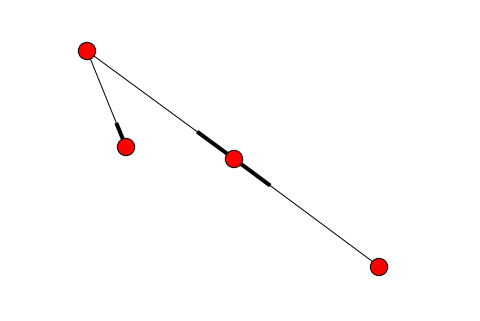

In [15]:
import networkx as nx
%matplotlib inline

results = %cypher MATCH p = (:Person)-[:LIKES]->(:Drink) RETURN p

g = results.get_graph()

nx.draw(g)

In [16]:
g.nodes(data=True)

[(u'19', {u'calories': 9000, 'labels': [u'Drink'], u'name': u'Mountain Dew'}),
 (u'18', {u'age': 20, 'labels': [u'Person'], u'name': u'Drew'}),
 (u'20', {u'calories': 0, 'labels': [u'Drink'], u'name': u'Coke Zero'}),
 (u'6', {u'age': 24, 'labels': [u'Person'], u'name': u'Nicole'})]

In [17]:
nx.degree(g)

{u'18': 1, u'19': 2, u'20': 1, u'6': 2}

# igraph

Cypher query results can be imported into `igraph` with `py2neo`. You'll need to install `igraph` with `pip install python-igraph`. Query results should be returned as edgelists, as `igraph` has a method for building an `igraph` object from a list of tuples representing edges between nodes.

In [18]:
from py2neo import Graph as PGraph
from igraph import Graph as IGraph

neo4j = PGraph()

query = """
MATCH (person:Person)-[:LIKES]->(drink:Drink)
RETURN person.name, drink.name
"""

data = neo4j.cypher.execute(query)
data

   | person.name | drink.name  
---+-------------+--------------
 1 | Nicole      | Mountain Dew
 2 | Nicole      | Coke Zero   
 3 | Drew        | Mountain Dew

In [19]:
ig = IGraph.TupleList(data)

ig

In [20]:
best = ig.vs.select(_degree = ig.maxdegree())["name"]
best

[u'Nicole', u'Mountain Dew']

## graph3d

`graph3d`, originally named [`igraph`](https://github.com/patrickfuller/igraph) but which I've [forked and renamed](https://github.com/nicolewhite/igraph) to avoid conflicts with the other `igraph`, will plot tuple lists as 3D graphs.

In [21]:
import graph3d

graph3d.draw([(1, 2), (2, 3), (3, 4), (4, 1), (4, 5), (5, 2)])

We can visualize our Neo4j data by pulling out an edgelist with a Cypher query.

In [22]:
data = graph.cypher.execute("MATCH (n)-->(m) RETURN ID(n), ID(m)")
data = [tuple(x) for x in data]

graph3d.draw(data)